# SLCP with NRE

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

from lampe.data import SimulatorLoader, H5Loader, h5save
from lampe.nn import NRE, NREPipe
from lampe.mcmc import InferenceSampler
from lampe.plots import corner
from lampe.simulators.slcp import SLCP, slcp_prior, lower, upper, labels
from lampe.train import collect

## Data

In [2]:
sim = SLCP()
prior = slcp_prior()

theta = prior.sample()
x = sim(theta)

theta, x

(tensor([ 0.3000,  1.8476, -1.2630,  0.8762,  2.7738]),
 tensor([[-0.2955,  1.6379],
         [ 0.9420,  2.1774],
         [ 1.2021,  2.4567],
         [-0.7462,  1.1522]]))

## Network

In [3]:
embedding = nn.Flatten(-2)
estimator = NRE(5, 8, hidden_features=[256] * 5, activation='ELU')

embedding.cuda()
estimator.cuda()

NRE(
  (standardize): Identity()
  (broadcast): Broadcast(keep=1)
  (net): MLP(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=256, out_features=1, bias=True)
  )
)

## Training

In [4]:
train_loader = H5Loader('train.h5', batch_size=2**10, pin_memory=True)
valid_loader = H5Loader('valid.h5', batch_size=2**10, pin_memory=True, shuffle=False)

In [5]:
pipe = NREPipe(estimator, embedding=embedding).cuda()
optimizer = optim.AdamW(pipe.parameters(), lr=1e-3, weight_decay=1e-3)

In [6]:
pipe.train()

with tqdm(range(64), unit='epoch') as tq:
    for epoch in tq:
        train_losses = collect(
            pipe,
            train_loader,
            optimizer,
            grad_clip=1.,
        )

        with torch.no_grad():
            valid_losses = collect(pipe, valid_loader)

        tq.set_postfix(
            train_loss=train_losses.mean().item(),
            valid_loss=valid_losses.mean().item(),
        )

_ = pipe.eval()

100%|██████████| 64/64 [11:07<00:00, 10.43s/epoch, train_loss=0.0454, valid_loss=0.0567]


## Evaluation

In [7]:
theta = torch.tensor([0.3517, -0.0883, -1.4778, 1.6406, -1.9085])
x = sim(theta)

In [8]:
sampler = InferenceSampler(x, prior.cpu(), likelihood=sim.log_prob, batch_size=2**12, sigma=5e-1)
samples = torch.cat([t for t in sampler(2**8, burn=2**6, step=2**2)])

with torch.no_grad():
    y = embedding(x.cuda())

    sampler = InferenceSampler(y, prior.cuda(), ratio=estimator, batch_size=2**12, sigma=5e-1)
    nre_samples = torch.cat([t.cpu() for t in sampler(2**8, 2**6, step=2**2)])

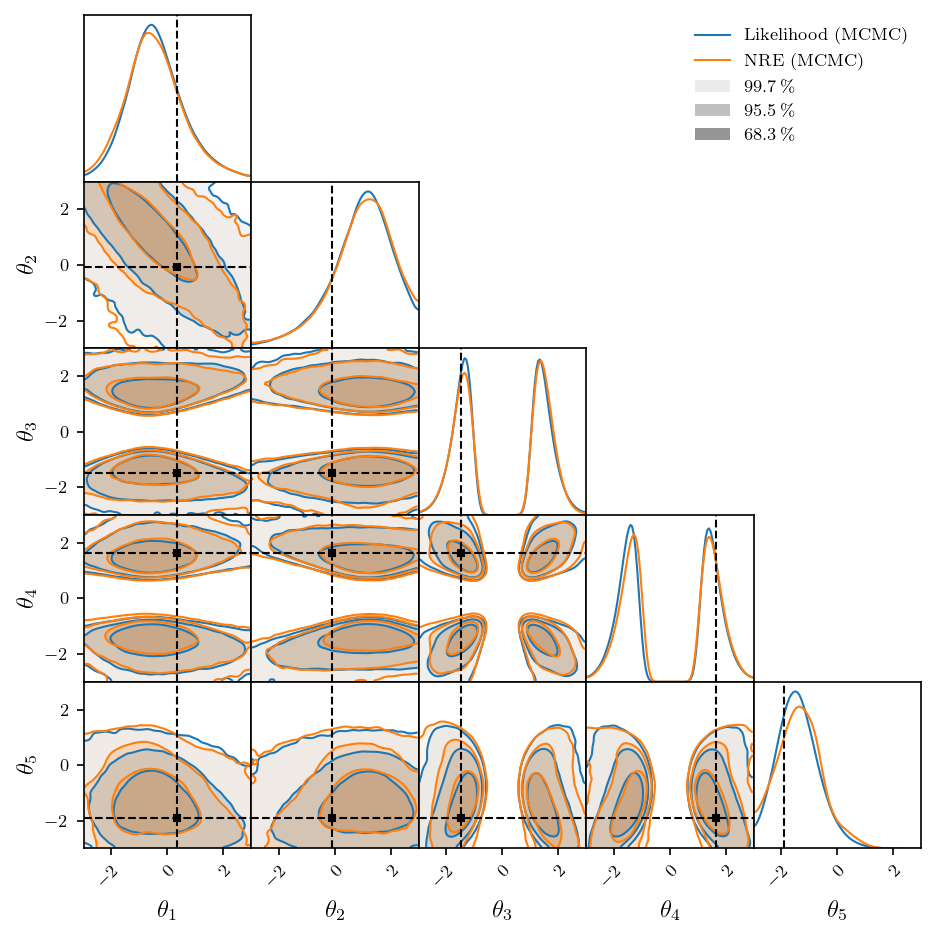

In [9]:
fig = corner(
    samples,
    smooth=2.,
    bounds=(lower, upper),
    labels=labels,
    legend='Likelihood (MCMC)',
    markers=[theta],
)

fig = corner(
    nre_samples,
    smooth=2.,
    bounds=(lower, upper),
    legend='NRE (MCMC)',
    figure=fig,
)